## Task : Implement CNN in numpy with both forward and backward propagation

In [7]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
%matplotlib inline
%config Completer.use_jedi = False

#### Firstly we will implement padding on the input image, with zeros

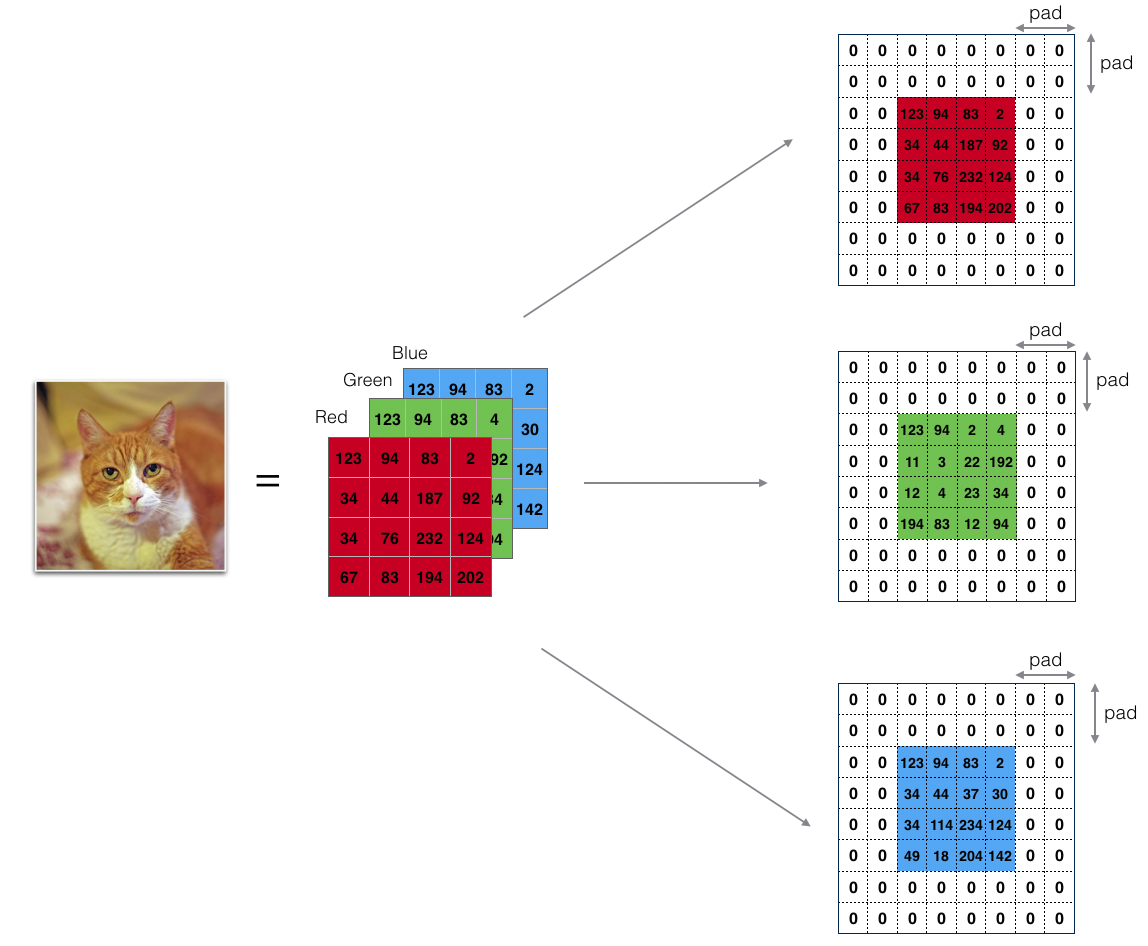

In [19]:
def padItPls(X,pad) : 
    '''
    X -> shape (m,nH,nW,nC)
    we need to pad as
    X_padded = (m,nH + 2*pad,nW + 2*pad,nC)
    '''
    return np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)), mode='constant', constant_values = (0,0))

#### Now we will implement a single step of convolution, where we apply the filter to a single positioned window of input

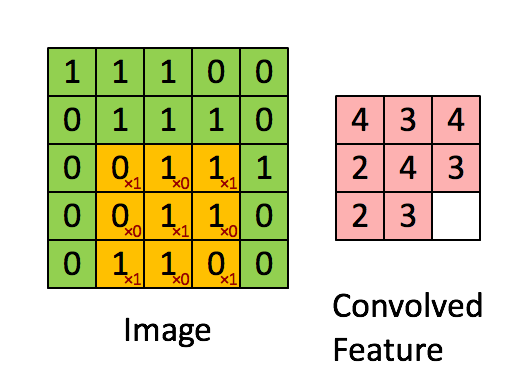

In [17]:
def conv_single_step(a_slice,w,b) : 
    '''
    a_slice = the portion/slice of the input data
    w = the parameters contained in window of shape (f,f,nC_prev)
    b = the paramters contained in window of shape (1,1,1
    '''
    s = np.multiply(a_slice,w) # element wise multiplication
    Z = np.sum(s) # summing the products
    Z = Z + float(b) # adding bias
    return Z

#### It's Time to implement the forward pass

The formulas of output shape of convolution of input shape : 

In [22]:
def conv_forward(A_prev,W,b,hparams) : 
    
    '''
    A_prev - Output activations of previous layer shape (m,nH_prev,nW_prev,nC_prev)
    W - Weights of shape (f,f,nC_prev,nC)
    b - Biases of shape (1,1,1,nC)
    hparams - Contains stride and padding details
    '''
    
    # Getting details from previous activations
    (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
    
    # Getting details from weights
    (f,f,nC_prev,nC) = W.shape
    
    # Getting stride and pad details from hparams
    stride = hparams['stride']
    pad = hparams['pad']
    
    # Computing the new height and width of the output after this forward pass
    nH = (nH_prev - f + 2*pad)//stride + 1
    nW = (nW_prev - f + 2*pad)// stride + 1
    
    # Initalizing Output Z with zeros
    Z = np.zeros([m,nH,nW,nC])
    
    # Pad the A_prev input 
    A_prev_padded = padItPls(A_prev,pad)
    
    # Start the forward pass
    for i in range(0,m) : 
    
        # Selecting the ith training image/example 
        a_prev_pad = A_prev_padded[i] 
    
        # Now we need to find the slice in this ith example
        # To do that we need 2 things : 
           # 1. The vertical start and end of the slice
           # 2. The horizontal start and end of the slice 
        # After this we can loop over the depth (channels) of that slice and use our single step convolution 
        
        for h in range(0,nH):
            v_start = stride * h # start vertically is the stride step times the height
            v_end = v_start + f #  end is from start till the filter size window's dimension
            
            for w in range(0,nW) : 
                h_start = stride * w
                h_end = h_start + f
                
                for c in range(nC) : 
                    # now we loop over the channels and here we first define out the slice on basis of above
                    # 2 for loop of height and width of slice window
                    # for ith example, limiting from v_start to v_end vertically and h_start to h_end horizontally
                    a_slice_prev = A_prev_padded[i,v_start:v_end,h_start:h_end,:]
                    
                    # Convolving the 3-dimensional slice with the filter of same size but per channel c
                    weight = W[:,:,:,c]
                    bias = b[:,:,:,c]
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,weight,bias)
         
    # saving other details for backprop
    cache = (A_prev,W,b,hparams)
    
    return Z,cache
            

#### Let's now implement Pooling layer
We will implement both Max and Avg Pooling layers in single function which is argument dependent

Max | Avg
 -  |  -
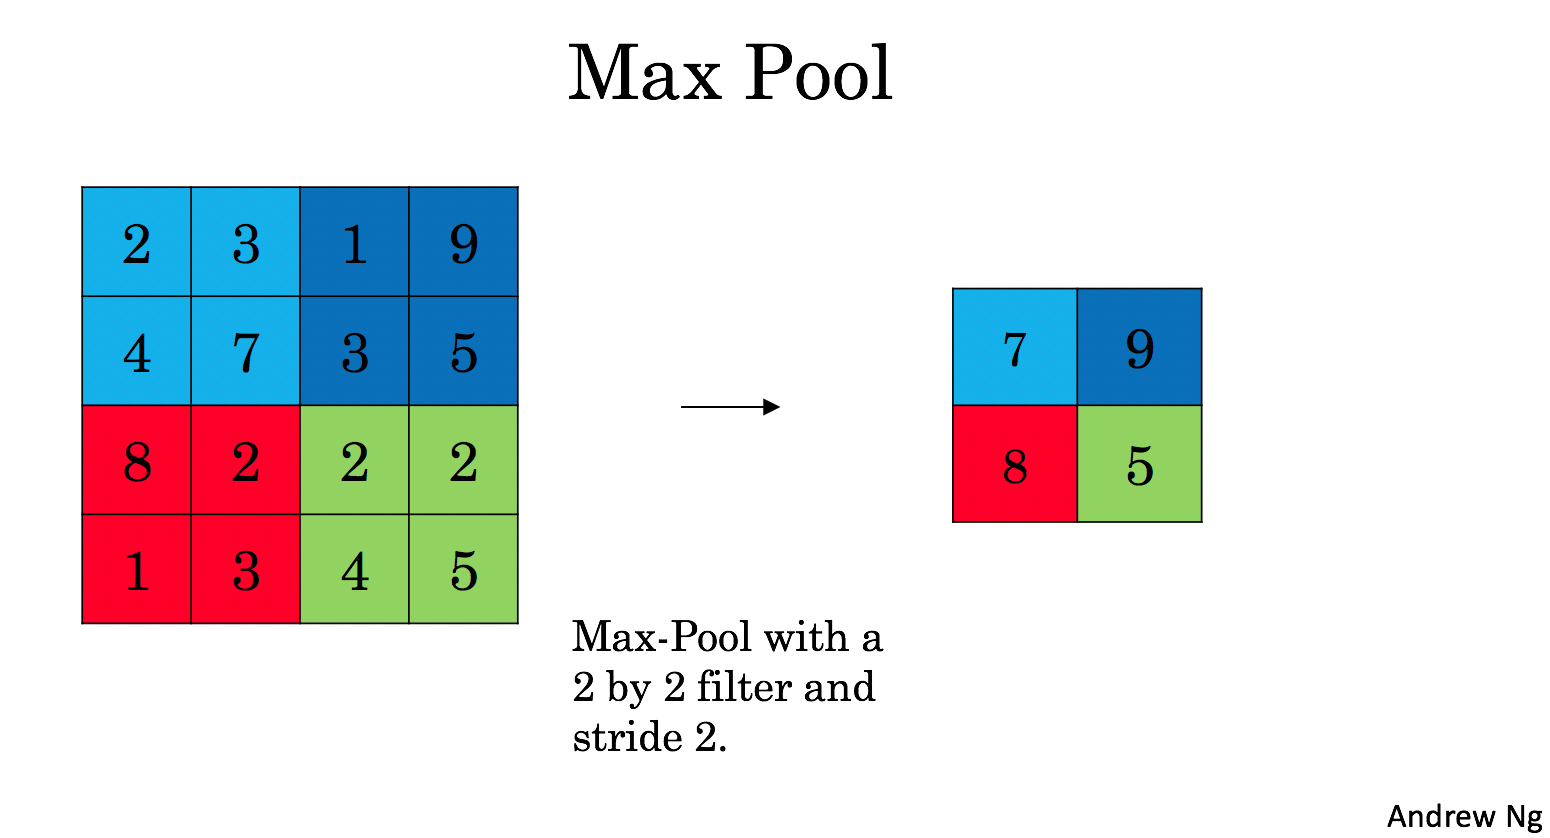 | 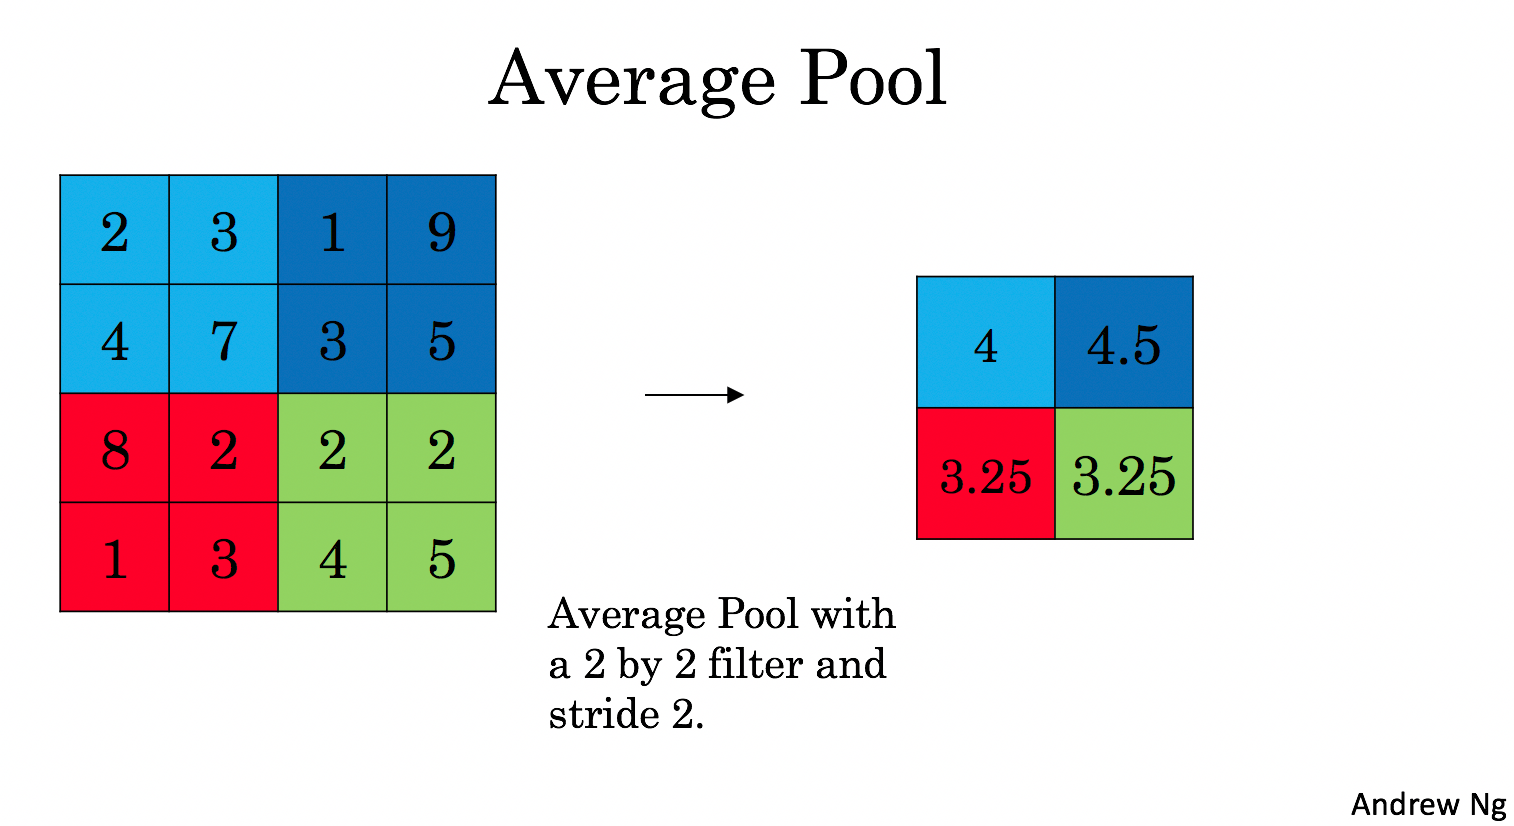

In [27]:
def pool_forward(A_prev,hparams,mode = 'max') : 
    
    (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
    stride = hparams['stride']
    f = hparams['f']
    
    # Dimensions of output
    nH = (nH_prev -f)//stride + 1
    nW = (nW_prev -f)//stride + 1
    nC = nC_prev
    
    # Initialize output matrix A
    A = np.zeros([m,nH,nW,nC])
    
    for i in range(m) : 
        
        for h in range(nH) : 
        
            v_start = stride * h
            v_end = v_start + f
            
            for w in range(nW) : 
            
                h_start = stride * w
                h_end = h_start + f
                
                for c in range(nC) : 
                    if mode == 'max' :
                        A[i,h,w,c] = np.max(A_prev[i,v_start : v_end,h_start : h_end,c])
                    elif mode == 'avg' : 
                        A[i,h,w,c] = np.mean(A_prev[i,v_start : v_end,h_start : h_end,c])
                        
    cache = (A_prev,hparams)
    
    return A,cache

#### It's time to implement Backprop

First we need to understand the computations being processed for backprop

**1. Computing dA :**


Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices.

**2. Computing dW :**


Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$.

**3. Computing db :**


db is computed by summing $dZ$. Here we are just summing over all the gradients of conv output (Z) with respect to the cost.

In [30]:
def conv_backward(dZ,cache) : 
    
    # Getting details back from cache
    (A_prev,W,b,hparams) = cache
    
    # Getting stuff from A_prev
    (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
    
    # Getting filter info from W
    (f,f,nC_prev,nC) = W.shape
    
    stride = hparams['stride']
    pad = hparams['pad']
    
    # Getting details from dZ
    (m,nH,nW,nC) = dZ.shape
    
    # Initializing dA_prev,dW,db
    dA_prev = np.zeros([m,nH_prev,nW_prev,nC_prev])
    dW = np.zeros((f,f,nC_prev,nC))
    db = np.zeros((1,1,1,nC))
    
    # Padding A_prev and dA_prev
    A_prev_padded = padItPls(A_prev,pad)
    dA_prev_padded = padItPls(dA_prev,pad)
    
    for i in range(m) : 
        
        a_prev_pad = A_prev_padded[i]
        da_prev_pad = dA_prev_padded[i]
        
        for h in range(nH) : 
            for w in range(nW) : 
                for c in range(nC) : 
                    
                    v_start = stride * h
                    v_end = v_start + f
                    
                    h_start = stride * w
                    h_end = h_start + f
                    
                    a_slice = a_prev_pad[v_start : v_end , h_start : h_end , :]
                    
                    # Updating grads for the chosen slice/window and filter's parameters 
                    da_prev_pad[v_start : v_end, h_start : h_end , :] += W[:,:,:,c] * dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
                    
        # Setting the ith example's dA_prev to unpadded da_prev_pad (unpadding basically)
        dA_prev[i,: , :, : ] = da_prev_pad[pad:-pad,pad:-pad, :]
        
    return dA_prev,dW,db
                    

#### Backward pass through the Pooling layer

Even though pooling layer has no parameters for backprop to update, we still need to backpropagate the gradient through the pooling layer in order to compute the gradients for layers that came before the pooling layer

For this in order to work, we need to keep track of the position of max ( in Max Pooling mode) and keep track of every element in input window ( in Avg Pooling mode) as in both the case these input values are the ones that ultimately influenced the output and therfore the cost

And anything that influences the ultimate cost has a non zero gradient

So we will have helper functions for both pooling modes

 this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0)

In [33]:
def create_mask_from_window(x) : 
    mask = (x == np.max(x))
    return mask

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: $$ dZ = 1 \quad \rightarrow \quad dZ =\begin{bmatrix} 1/4 &  1/4 \\ 1/4 & 1/4 \end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average.

In [34]:
def distribute_value(dz,shape) : 
    
    (nH,nW) = shape
    average = dz/(nH * nW)
    a = np.ones(shape) * average
    return a

#### Backward Pooling time

In [36]:
def pool_backward(dA,cache,mode = 'max') : 
    
    (A_prev,hparams)  = cache
    stride = hparams['stride']
    f = hparams['f']
    
    m,nH_prev,nW_prev,nC_prev = A_prev.shape
    m,nH,nW,nC = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m) : 
        a_prev = A_prev[i]
        for h in range(nH) : 
            for w in range(nW) :
                for c in range(nC) : 
                    
                    v_start = stride * h
                    v_end = v_start + f
                    
                    h_start = stride * w
                    h_end = h_start + f
                    
                    if mode == 'max' : 
                        
                        a_prev_slice = a_prev[v_start : v_end, h_start : h_end,c]
                        
                        # create mask from a_prev_slice
                        mask = create_mask_from_window(a_prev_slice)
                        
                        # Setting dA_prev to be dA_prev + (the mask multiplied by correcty entry of dA)
                        
                        dA_prev[i,v_start : v_end,h_start:h_end,c] += np.multiply(mask,dA[i,h,w,c])
                    
                    elif mode == 'avg' :
                        
                        da = dA[i,h,w,c]
                        shape = (f,f)
                        # Distributing the da to get the corrected slice of dA_prev (basically adding the distributed value of da)
                        dA_prev[i,v_start:v_end,h_start:h_end,c] += distribute_value(da,shape)
                        
            
            return dA_prev

In [38]:


np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])



mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[0. 0.]
 [0. 0.]
 [0. 0.]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[0. 0.]
 [0. 0.]
 [0. 0.]]
